<a href="https://colab.research.google.com/github/KZoc/Formacao-ApacheSpark-Com-Python-Alura/blob/main/Projeto1-PNL-e-Classificacao/Projeto1_Processamento_de_Linguagem_Natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Sessão e leitura dos dados**

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# Instalando o PySpark
!pip install pyspark

In [54]:
# Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [55]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive

dados = spark.read.csv("/content/drive/MyDrive/Alura/Curso-Spark/Processanento Linguagem Natural/imdb-reviews-pt-br.csv",
                       escape='\"',
                       header=True,
                       inferSchema=True)

### **Explorando os dados**



In [56]:
# Verificando número de linhas e colunas

print(f'Nº de Linhas = {dados.count()}\n',f'Nº de Colunas = {len(dados.columns)}')

Nº de Linhas = 49459
 Nº de Colunas = 4


In [57]:
# Verificar os campos e os tipos

dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [58]:
# Vizualizar o conteúdo dos campos

dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



In [59]:
# Verificar os tipos de 'sentimentos' existentes no dataset

dados.select('sentiment').distinct().show()

+---------+
|sentiment|
+---------+
|      pos|
|      neg|
+---------+



In [60]:
# Agora quero ver um comentário positivo e um negativo

# Para ver o comentario positivo, primeiro preciso saber o id de algum,
# então vou usar o seguinte comando:

dados.filter(dados.sentiment == 'pos').select ('id', 'text_pt', 'sentiment').limit(1).show(truncate = False)

+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|id   |text_pt                                                                                                                                                             

In [61]:
# Encontrado um comentário positivo, vou "comparar" os dois tipos de comentários (negativo e positivo)

print('Comentário POSITIVO:')
dados.filter(dados.id == 12391).select('text_pt').show(truncate = False)
print('Comentário NEGATIVO:')
dados.filter(dados.id == 10).select('text_pt').show(truncate = False)

Comentário POSITIVO:
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                                                              

In [62]:
# Verificando a distribuição dos dados (QTDE de pos e neg)

dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



### Inicinando Processo de WordCloud

In [63]:
# Importando as bibliotecas que utilizarei

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [64]:
# Colhendo uma amostra dos dados para analisar quais são as palavras mais utilizadas

sample = dados.select('text_pt').sample(fraction=0.1, seed=101)

In [65]:
# Criando uma lista de palavras com as amostras

list_words = [texto['text_pt'] for texto in sample.collect()]

In [66]:
# Criando a instância wordcloud

wordcloud = WordCloud(
    background_color='white',
    width = 1000,
    height = 600,
    collocations = False,
    prefer_horizontal = 1
).generate(str(list_words))

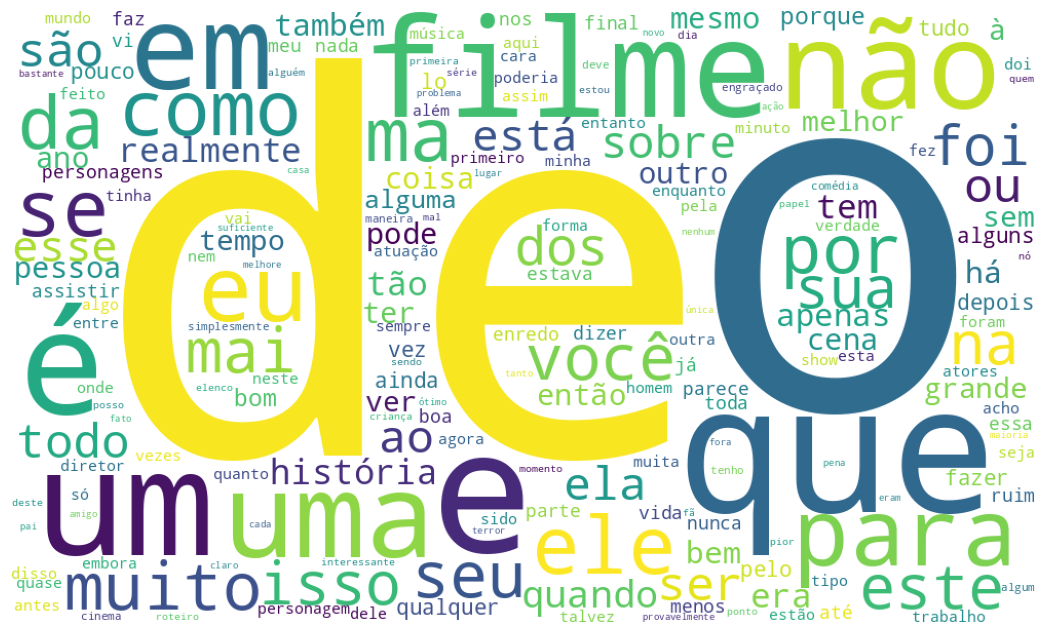

In [67]:
# Configurando a figura que mostrará a word cloud

plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Removendo caracteres especiais

In [68]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [69]:
# Para testar o código de remoção utilizarei um texto de amostra

amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])

In [70]:
import pyspark.sql.functions as f

amostra = amostra.withColumn('texto_regex', f.regexp_replace('textos', "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ''))

In [71]:
amostra.show(truncate= False)

+------------------------------------------+------------------------------+
|textos                                    |texto_regex                   |
+------------------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |
|"bora *_* "                               |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |
|ana@gmail.com                             |anagmailcom                   |
+------------------------------------------+------------------------------+



In [72]:
# Agora vou remover os espaços do texto

amostra = amostra.withColumn('texto_limpo', f.trim(amostra.texto_regex))

In [73]:
amostra.show(truncate=False)

+------------------------------------------+------------------------------+-----------------------------+
|textos                                    |texto_regex                   |texto_limpo                  |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]

In [74]:
# Agora aplicarei essa sequência de limpeza ao conjunto de dados em análise na coluna 'text_en'

dados = dados.withColumn('texto_regex', f.regexp_replace('text_en', "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ''))

In [75]:
dados.limit(3).show(truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [76]:
dados = dados.withColumn('texto_limpo', f.trim(dados.texto_regex))
dados.limit(3).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



#### Fazendo a Tokenização dos dados

In [77]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens_1')
tokenizado = tokenizer.transform(dados)

In [78]:
tokenizado.select('texto_limpo', 'tokens_1').show()

+--------------------+--------------------+
|         texto_limpo|            tokens_1|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [79]:
# Fazendo a contagem de tokens gerados para cada avaliação

from pyspark.sql.types import IntegerType

countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado = tokenizado.select('texto_limpo', 'tokens_1').withColumn('Freq_tokens_1', countTokens(f.col('tokens_1')))

tokenizado.select('texto_limpo', 'tokens_1', 'Freq_tokens_1').show()

+--------------------+--------------------+-------------+
|         texto_limpo|            tokens_1|Freq_tokens_1|
+--------------------+--------------------+-------------+
|Once again Mr Cos...|[once, again, mr,...|          168|
|This is an exampl...|[this, is, an, ex...|          232|
|First of all I ha...|[first, of, all, ...|          215|
|Not even the Beat...|[not, even, the, ...|          308|
|Brass pictures mo...|[brass, pictures,...|          238|
|A funny thing hap...|[a, funny, thing,...|          115|
|This German horro...|[this, german, ho...|          156|
|Being a longtime ...|[being, a, longti...|          136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|          129|
|Wealthy horse ran...|[wealthy, horse, ...|          160|
|Cage plays a drun...|[cage, plays, a, ...|          109|
|First of all I wo...|[first, of, all, ...|          333|
|So tell me  what ...|[so, tell, me, , ...|          243|
|A big disappointm...|[a, big, disappoi...|          110|
|This film is 

#### EXTRA: Utilizando Regex e Tokenização em uma só função = RegexTokenizer()

In [80]:
from pyspark.ml.feature import RegexTokenizer

reTokenizer = RegexTokenizer()

In [81]:
# Set dos parâmetros básicos e vizualização

reTokenizer.setParams(inputCol='texto_limpo', outputCol='tokens_2',)
tokenizado_alter2 = reTokenizer.transform(tokenizado)
tokenizado_alter2.show()

+--------------------+--------------------+-------------+--------------------+
|         texto_limpo|            tokens_1|Freq_tokens_1|            tokens_2|
+--------------------+--------------------+-------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|          168|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|          232|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|          215|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|          308|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|          238|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|          115|[a, funny, thing,...|
|This German horro...|[this, german, ho...|          156|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|          136|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|          129|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|         

In [82]:
# Fazendo contagem dos tokens gerados utilizando a mesma função criada anteriormente

from pyspark.sql.types import IntegerType

countTokens = f.udf(lambda tokens: len(tokens), IntegerType())

tokenizado_alter2 = tokenizado_alter2.withColumn('Freq_tokens_2', countTokens(f.col('tokens_2')))

tokenizado_alter2.select('texto_limpo', 'tokens_2', 'Freq_tokens_2').show()

+--------------------+--------------------+-------------+
|         texto_limpo|            tokens_2|Freq_tokens_2|
+--------------------+--------------------+-------------+
|Once again Mr Cos...|[once, again, mr,...|          168|
|This is an exampl...|[this, is, an, ex...|          230|
|First of all I ha...|[first, of, all, ...|          215|
|Not even the Beat...|[not, even, the, ...|          308|
|Brass pictures mo...|[brass, pictures,...|          237|
|A funny thing hap...|[a, funny, thing,...|          115|
|This German horro...|[this, german, ho...|          156|
|Being a longtime ...|[being, a, longti...|          136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|          129|
|Wealthy horse ran...|[wealthy, horse, ...|          160|
|Cage plays a drun...|[cage, plays, a, ...|          109|
|First of all I wo...|[first, of, all, ...|          333|
|So tell me  what ...|[so, tell, me, wh...|          238|
|A big disappointm...|[a, big, disappoi...|          110|
|This film is 

In [83]:
# Comparando os resultados da quantidade de tokens gerados entre as duas alternativas usadas

tokenizado_alter2.select('Freq_tokens_1', 'Freq_tokens_2').limit(30).show()

+-------------+-------------+
|Freq_tokens_1|Freq_tokens_2|
+-------------+-------------+
|          168|          168|
|          232|          230|
|          215|          215|
|          308|          308|
|          238|          237|
|          115|          115|
|          156|          156|
|          136|          136|
|          129|          129|
|          160|          160|
|          109|          109|
|          333|          333|
|          243|          238|
|          110|          110|
|          185|          185|
|          205|          205|
|          148|          148|
|          196|          195|
|          350|          348|
|           77|           76|
+-------------+-------------+
only showing top 20 rows



In [84]:
# Com base nesses números, posso ver pequenas diferenças apenas em alguns itens.

#### StopWords


##### Teste de Remoção das Stopwords em um conjunto de dados de teste

In [85]:
# Aqui a coluna label é referente ao sentimento do comentário do exemplo, sendo, 1 positivo e 0 negativo

data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
                (0, 'Spark MLlib não ajuda muito'),
                (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']
df_teste = spark.createDataFrame(data, colNames)

Testarei duas bibliotecas com coleções de stopwords: a do NLTK e a nativa do Spark

In [86]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [88]:
# Para aplicar a remoção das stopwords é preciso ,primeiro, tokenizar os textos

from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')
tokenized = tokenizer.transform(df_teste)

In [89]:
# Agora prepararei o meu removedor de stopwords

remover = StopWordsRemover(inputCol = 'tokens', outputCol = 'texto_final', stopWords = stop_A)
df_teste = remover.transform(tokenized)

In [90]:
df_teste.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [91]:
# Agora utilizando o conjunto de stopwords do Spark

remover = StopWordsRemover(inputCol = 'tokens', outputCol= 'texto_final', stopWords = stop_B)
df_teste = remover.transform(tokenized)

In [92]:
df_teste.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



Comparando os dois resultados, vi que na lista de stopwords do Spark a palavra "é" não está inclusa.

#### Aplicando a remoção das stopwords nos dados em análise

In [93]:
remover = StopWordsRemover(inputCol = 'tokens_1', outputCol = 'texto_final')
feature_data = remover.transform(tokenizado)

In [94]:
feature_data.limit(7).show()

+--------------------+--------------------+-------------+--------------------+
|         texto_limpo|            tokens_1|Freq_tokens_1|         texto_final|
+--------------------+--------------------+-------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|          168|[mr, costner, dra...|
|This is an exampl...|[this, is, an, ex...|          232|[example, majorit...|
|First of all I ha...|[first, of, all, ...|          215|[first, hate, mor...|
|Not even the Beat...|[not, even, the, ...|          308|[even, beatles, w...|
|Brass pictures mo...|[brass, pictures,...|          238|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|          115|[funny, thing, ha...|
|This German horro...|[this, german, ho...|          156|[german, horror, ...|
+--------------------+--------------------+-------------+--------------------+



In [95]:
# Agora vou contar quantos tokens restaram após a remoção das stopwords

feature_data.select('Freq_tokens_1', 'texto_final')\
            .withColumn('Freq_tokens_limpos', countTokens(f.col('texto_final'))).show()

+-------------+--------------------+------------------+
|Freq_tokens_1|         texto_final|Freq_tokens_limpos|
+-------------+--------------------+------------------+
|          168|[mr, costner, dra...|                73|
|          232|[example, majorit...|               131|
|          215|[first, hate, mor...|               111|
|          308|[even, beatles, w...|               169|
|          238|[brass, pictures,...|               140|
|          115|[funny, thing, ha...|                52|
|          156|[german, horror, ...|                74|
|          136|[longtime, fan, j...|                73|
|          129|[tokyo, eyes, tel...|                75|
|          160|[wealthy, horse, ...|                99|
|          109|[cage, plays, dru...|                58|
|          333|[first, like, say...|               140|
|          243|[tell, , serious,...|               139|
|          110|[big, disappointm...|                50|
|          185|[film, absolutely...|            

#### Bag of Words

##### CountVectorizer()

In [96]:
# Importando o CountVectorizer e testando no dataframe de exemplo usado anteriormente

from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol = 'texto_final', outputCol = 'CountVec')
model = cv.fit(df_teste)
df_teste = model.transform(df_teste)

In [97]:
df_teste.select('texto_final', 'CountVec').show(truncate = False)

+---------------------------------------+-------------------------------------+
|texto_final                            |CountVec                             |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,3,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,2,4],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



In [98]:
model.vocabulary

['spark', 'é', 'mllib', 'fácil', 'ajuda', 'nlp', 'ótimo']

In [99]:
# Aplicando no conjunto de dados em análise

from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol = 'texto_final', outputCol = 'CountVec')
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

In [100]:
countVectorizer_features.select('texto_final', 'CountVec').limit(5).show()

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(216710,[0,7,8,11...|
|[example, majorit...|(216710,[1,2,3,8,...|
|[first, hate, mor...|(216710,[0,2,4,11...|
|[even, beatles, w...|(216710,[0,1,2,4,...|
|[brass, pictures,...|(216710,[1,3,5,8,...|
+--------------------+--------------------+



##### Hashing TF

In [101]:
#    O Hashing TF é uma alternativa ao CountVectorizer
# ele permite limitar o número de palavras contabilizadas

from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol = 'texto_final', outputCol = 'hashingTF')
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [102]:
HTFfeaturizedData.select('texto_final', 'hashingTF').limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



#### TF-IDF

O TF-IDF é uma medida estatística que visa indicar a importância de uma palavra em relação ao conjunto. É frequentemente utilizado como fator de ponderação na recuperação de informações e na mineração de dados. Em suma, este processo atribuirá um peso para cada uma das palavras.

In [104]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol = 'hashingTF', outputCol = 'feature')
idfmodel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfmodel.transform(HTFfeaturizedData)

In [105]:
TFIDFfeaturizedData.select('texto_final', 'feature').limit(5).show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Pipeline de Transformação dos Dados

Ao verificar o campo 'sentiment', vimos que "pos" refere-se à positivos, e "neg", à negativos.

No PySpark, também precisamos codificar essas variáveis transformando-as em número. Para isso, vou usar StingIndexer.

Após, com apenas uma célula criarei um pipeline de transformação dos dados, que será com base nas etapas que fiz anteriormente quando explorava os dados e verificava os retornos.

#### Codificação da Variável resposta

In [110]:
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [111]:
# Aqui codifico a variável resposta para que ela possa ser interpretada pelo modelo posteriormente.

from pyspark.ml.feature import StringIndexer

stringindexer = StringIndexer(inputCol = 'sentiment', outputCol = 'label')
dados = stringindexer.fit(dados).transform(dados)

In [112]:
# Aqui poderei saber a qual número cada sentimento foi atribuido.
# Como podemos ver abaixo, 'pos' = 1 e 'neg' = 0

dados.groupBy(['sentiment', 'label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



#### Pipeline de transformação dos dados

In [113]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens')
stopwords = StopWordsRemover(inputCol = 'tokens', outputCol = 'texto_final')
hashingTF = HashingTF(inputCol = stopwords.getOutputCol(), outputCol = 'HTF', numFeatures = 1000)
tfidf = IDF(inputCol = 'HTF', outputCol = 'features')

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

In [114]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [115]:
dados_transformados.limit(2).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
+---+--------------------+--------------------+---

### Preparando Modelo de Machine Learning

#### Decision Tree Classifier

In [117]:
# Aqui incluirei o modelo de Decision Tree dentro da pipeline que fiz anteriormente


from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens')
stopwords = StopWordsRemover(inputCol = 'tokens', outputCol = 'texto_final')
hashingTF = HashingTF(inputCol = stopwords.getOutputCol(), outputCol = 'HTF', numFeatures = 1000)
tfidf = IDF(inputCol = 'HTF', outputCol = 'features')
dt = DecisionTreeClassifier(featuresCol= 'features', labelCol= 'label', maxDepth=10)


pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dt])


##### Amostras TREINO e TESTE

In [118]:
# Separando os dados

train, test = dados.randomSplit([0.7, 0.3], seed = 101)

In [119]:
# Ajustando o modelo com a pipeline

dt_model = pipeline.fit(train)

In [120]:
# Aplicando modelo nos dados de teste

predictions = dt_model.transform(test)

##### Teste e Métricas

In [125]:
# Visualizando as previsões e comparando com os dados reais

predictions.select(['label', 'prediction']).limit(10).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
+-----+----------+



In [126]:
# Calculando a ACURÁCIA

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol = 'prediction', metricName ='accuracy')

acuracia = evaluator.evaluate(predictions)

In [129]:
print("Acuracia = %s" % (acuracia))

Acuracia = 0.6700404858299596


In [131]:
# Testando com frases novas que decidi criar

nova_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "texto_limpo"])

In [132]:
nova_class = dt_model.transform(nova_base)

In [133]:
nova_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|  [18.0,10.0]|[0.64285714285714...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[156.0,774.0]|[0.16774193548387...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+



Para essas duas avaliações que criei o modelo acertou o sentimento expressado, sendo, a primeira 'negativo' e a segunda 'positivo'